In [ ]:
%%capture
!git clone https://github.com/matiasdperez/MEC_tesis.git

In [ ]:
import os
os.chdir('MEC_tesis/')

# Markov Switching Model


-------
_______

In [ ]:
%load_ext autoreload
%autoreload 2

## 1) Setup

In [ ]:
%%capture
! pip install dieboldmariano pmdarima keras-tuner tensorflow-addons

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import warnings
import tqdm as tqdm
import random
from sklearn.preprocessing import StandardScaler
from dieboldmariano import dm_test

pd.set_option('max_colwidth', 400)
warnings.filterwarnings("ignore")

np.random.seed(42)

from utils.simulators import MarkovSwitchingModel
from utils.statistical_models import *
from utils.NN_models import *

## 2) Simulación

Se instancian 2 objetos de la clase MarkovSwitchingModel y se simulan 1,000 timesteps bajo las especificaciones ya mencionadas y tomando como valor inicial 0:

In [ ]:
n_steps = 1000
random_seed = 42

In [ ]:
msm2 = MarkovSwitchingModel(n_steps=n_steps,
                            model_type = 'AR_1_with_intercept',
                            state_space_dim = 2,
                            transition_matrix = [[0.75, 0.25],
                                                [0.10, 0.90]],
                            intercept = [0, 1],
                            AR_1_parameter = [0.95, 0.5],
                            random_seed = random_seed
)
msm2.simulate(initial_state = 'steady_state')

msm3 = MarkovSwitchingModel(n_steps=n_steps,
                            model_type = 'all',
                            state_space_dim = 3,
                            transition_matrix = [[0.75, 0.25, 0],
                                                [0.2, 0.60, 0.2],
                                                [0, 0.2, 0.8]],
                            intercept = [0, 0.5, 1],
                            AR_1_parameter = [0.99, 0.5, 0.25],
                            variance = [0.5, 1, 2],
                            random_seed = random_seed
)
msm3.simulate(initial_state = 'random')

Steady state distribution exists and it's unique.


Simulating: 1000it [00:00, 18726.58it/s]           
Simulating: 1000it [00:00, 8828.42it/s]                        


De las 1,000 observaciones simuladas, las primeras 750 constituyen el dataset de entrenamiento y las segundas 250, el de test.

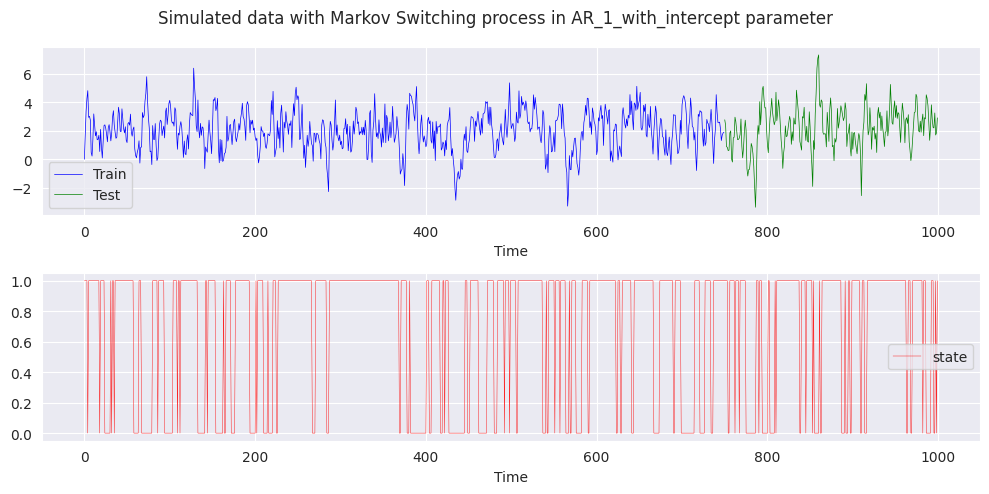

In [ ]:
split_index = int(len(msm2.y) * 0.75)

msm2.plot(split_index = split_index)


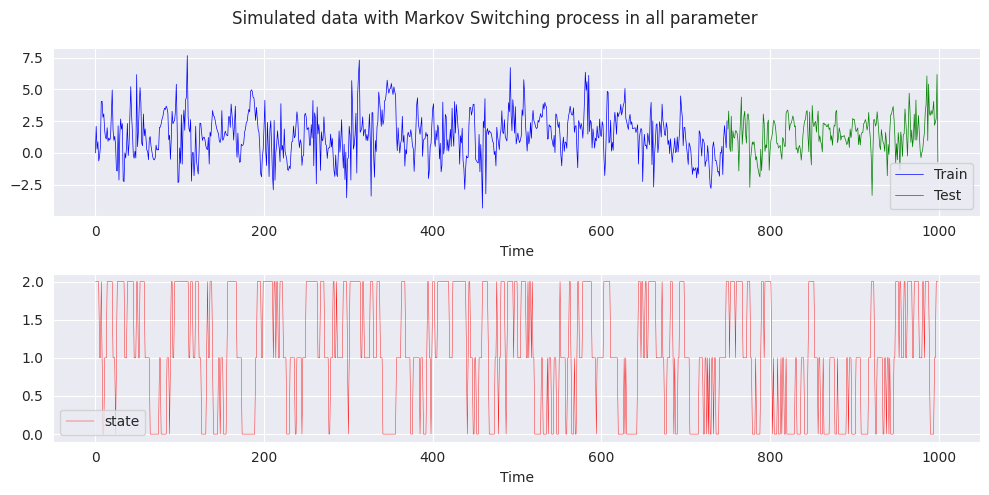

In [ ]:
msm3.plot(split_index = split_index)

A continuación se presentan las funciones de autocorrelación y autocorrelación parcial para los dos modelos. En ambos casos se observa evidencia de la presencia de raíz unitaria en los procesos: un ACF empírica que decrece muy lentamente y una PACF en la que solo es estadísticamente significativo el primer lag.

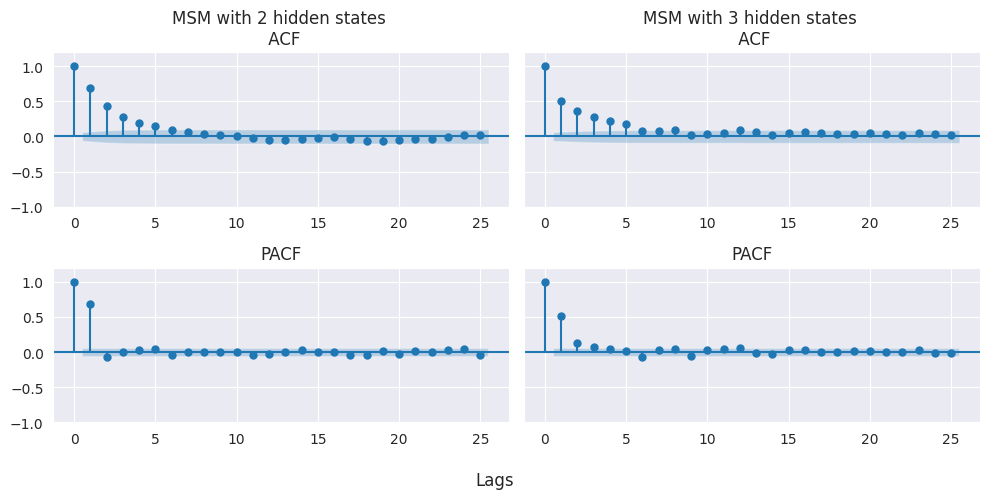

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharey=True)

plot_acf(msm2.y, lags=25, ax=axs[0,0])
plot_pacf(msm2.y, lags=25, ax=axs[1,0])
axs[0,0].set_title("MSM with 2 hidden states \n ACF")
axs[0,0].set_ylim([-1, 1.2])
axs[1,0].set_title("PACF")

plot_acf(msm3.y, lags=25, ax=axs[0,1])
plot_pacf(msm3.y, lags=25, ax=axs[1,1])
axs[0,1].set_title("MSM with 3 hidden states \n ACF")
axs[0,1].set_ylim([-1, 1.2])
axs[1,1].set_title("PACF")

fig.supxlabel('Lags')
plt.tight_layout()
plt.show()

A continuación se realiza el split en train-test para cada uno de los DGP simulados. Se toman el primer 75% de las observaciones para train (750 observaciones) y el restante 25% para test (250 observaciones).

In [ ]:
msm2_y_train, msm2_y_test = msm2.y[:split_index], msm2.y[split_index:]
msm3_y_train, msm3_y_test = msm3.y[:split_index], msm3.y[split_index:]

## 3) Cross-validation de hiperparámetros

En esta fase del workflow de trabajo, se utiliza el conjunto de entrenamiento y validación para buscar el set de hiperparámetros que mejor ajusta la forma funcional del modelo al problema concreto (i.e, aquel modelo que minimiza el error cuadrático medio sobre el conjunto de validación). Los espacios de hiperparámetros definidos para cada modelo son los siguientes:

1) <ins> Modelo ARIMA </ins>: se buscarán de manera automática la tupla (p,I,q), esto es, el orden del término autorregresivo AR, el orden de integración y el órden del término de medias móviles MA dentro de un espacio de hiperparámetros dado por el producto cartesiano especificado por el usuario. Por ejemplo: {0,1,2,3}x{0,1,2}x{0,1,2,3}.
A su vez, para el caso del modelo ARIMA, se utilizan 2 estrategias de cross-validation:

    * Rolling window
    * Sliding window

2) <ins> Modelo ETS </ins>: en el caso del modelo ETS, se buscarán de manera automática sobre un espacio de hiperparámetros que definen la forma funcional de las ecuaciones que rigen el modelo. El mismo se define como el producto cartesiano de los siguientes conjuntos:

    * error_type = {aditivo, multiplicativo}
    * trend_type = {sin_tendencia, aditiva, multiplicativa}
    * dampend_trend = {Verdado, Falso}
    * seasonal_component = {}

    Al igual que para el caso del modelo ARIMA, se utilizan las dos mismas estrategias de cross-validation.

3) <ins> Stacked LSTM </ins>: para el caso de las redes neuronales, se define una arquitectura general dado por el tipo de unidades o neuronas (en este caso, vanilla LSTM) y un espacio de hiperprámetros "grande", el cual no es explorado de manera exhaustiva sino que se escogen una serie de configuraciones de manera aleatoria y se recupera aquella configuración que minimiza la función de pérdida sobre el conjunto de validación (partición del conjunto de entrenamiento original). Una vez más, el espacio de hiperparámetros se construye como el cartesiano de los siguientes conjuntos:

    * Función de activación = {'relu', 'tanh', 'sigmoid', 'elu'} --> función de activación aplicadas a la cell state y al estado oculto de la red.
    * Unidades en la primera capa recurrente = {16, 32, 64, 128}
    * Incluir segunda capa LSTM = {True, False}
    * Unidades en la segunda capa recurrente (en caso de existir) = {16, 32, 64, 128}
    * Unidades en la capa densa = {16, 32, 64, 128} --> número de neuronas en la capa densa que transforma la salida vectorial de la red LSTM en el valor escalar a predecir.
    * Learning Rate = {1e-2, 1e-3, 1e-4} --> learning_rate utilizado por el optimizador en la búsqueda de los parámetros del modelo.
    * Optimizador = {'adam', 'sgd', 'rmsprop'}
    * Dropout rate = {0, 0.1, 0.2, 0.3, 0.4, 0.5} --> tasa de dropout, utilizada para eliminar conexiones entre neuronas de manera aleatoria durante la fase de entrenamientod de la red y así evitar overfitting
    * Inicializadores = {'random_normal','glorot_uniform', 'he_normal'} --> distribuciones de las que se samplean los valores iniciales de los pesos y biases de la red, y le da naturaleza estocástica al entrenamiento de la NN.
    * Coeficiente L2 = {0, 0.1, 0.2, 0.3, 0.4, 0.5} --> penalización utilizada para evitar que los pesos de la red "crezcan" demasiado y overfitteen la red (aka. weight decay).

4) <ins> LSTM con Peepholes </ins>: mismo espacio de búsqueda de hiperparámetros que el modelo *Stacked LSTM*

5) <ins> Encoder-Decoder LSTM </ins>: la única diferencia en el espacio de hiperparámetros frente a las otras arquitecturas es que en este modelo, en caso de existir una segunda capa oculta, se la fuerza a que tenga una dimensión menor al número de unidades de la primera capa oculta para lograr así la forma de "embudo" típico de las redes neuronales encoder-decoder.


### 3.1) ARIMA

In [ ]:
# Definición del espacio de hiperparámetros sobre el cual buscar la mejor configuración del modelo para el problema

AR_order = [0,1,2,3]
MA_order = [0,1,2,3]
I_order = [0,1,2]

# Dado que el espacio de búsqueda de hiperparámetros tiene una cardinalidad muy alta para realizar una búsqueda exhaustiva, se opta en su lugar
# por tomar una muestra de 30 combinaciones de hiperparámetros del espacio de búsqueda.

random.seed(1234)
search_space = random.sample(list(product(AR_order, I_order, MA_order)), 30)

A modo de ejemplo, se procede a cross-validar el modelo con el search_space recien construido y bajo las siguientes especificaciones:
* `h = 1`
* `stride = 25`
* `window_length = 50`
* `evaluation_metric = mean_squared_error`

El número de folds se determina de manera automática en base a la combinación de `h`, `stride` y `window_length`.

In [ ]:
msm2_vanilla = ArimaModel(msm2_y_train, msm2_y_test, **{'with_intercept':False, 'method':'nm'})

In [ ]:
msm2_vanilla.cross_validate(ARIMA_configs=search_space,
                              h = 1,
                              stride=25,
                              window_length=50,
                              eval_metric='mean_squared_error')

 97%|█████████▋| 29/30 [03:47<00:07,  7.15s/it]

A continuación se muestra el top 10 configuraciones de hiperparámetros, ordenados por la mediana del error cuadrático en cada fold para la estrategia `sliding_window`.

In [ ]:
msm2_vanilla.cross_validation_df.sort_values('sliding_median_MSE').head(10)

,AR_order,I_order,MA_order,rolling_median_MSE,sliding_median_MSE
16,0,2,1,0.573322,0.383395
25,2,2,1,0.776284,0.418523
26,1,2,1,0.704177,0.424307
3,0,1,1,0.693690,0.450532
19,2,2,2,0.515526,0.481761
22,1,1,0,0.665851,0.501563
15,2,1,1,0.599368,0.512636
8,1,2,2,0.473337,0.513172
24,3,2,2,0.344694,0.524941
27,1,1,1,0.722352,0.531180


In [ ]:
print(f"La mejor configuración para la estrategia de sliding window es: {msm2_vanilla.best_model('sliding')}")

La mejor configuración para la estrategia de sliding window es: (0, 2, 1)


Se generaliza la búsqueda del 'mejor conjunto' de hiperparámetros (p,I,q) para cada modelo, variando el horizonte de predicción `h` y utilizando distintos valores de `window_length` y un `stride` fijo de 25. En todos los casos se utiliza una estrategia de cross-validation de tipo `sliding_window` (de la interacción con el hiperparámetro `stride` surgirá si los folds se solapan o no) y la métrica a evaluar sobre el conjunto de validación es MSE.

In [ ]:
h_list = [1, 7]
strides_list = [25]
window_length_list = [25, 50, 100]

#### 3.1.1) Markov Switching Model con 2 estados

In [ ]:
msm2_arima_results = defaultdict(defaultdict)
msm_best_models = defaultdict((lambda: defaultdict(dict))) #En este diccionario se guardará el mejor modelo para cada DGP y combinación de h, stride y window_length

In [ ]:
%%time
for h in h_list:
    best_MSE = 9999
    for s, l in list(product(strides_list, window_length_list)):
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = ArimaModel(msm2_y_train, msm2_y_test, **{'with_intercept':False, 'method':'nm'})
        model.cross_validate(ARIMA_configs=search_space,
                                                       h = h,
                                                       stride=s,
                                                       window_length=l,
                                                       eval_metric='mean_squared_error')
        MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
        msm2_arima_results[h][(s, l)] = {
            'best_model': model.best_model('sliding'),
            'best_MSE': MSE
        }
        if MSE < best_MSE:
            best_MSE = MSE
            msm_best_models['msm2'][h]['arima'] = model

Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 30/30 [02:43<00:00,  5.45s/it]


Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 30/30 [02:45<00:00,  5.52s/it]


Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 30/30 [02:53<00:00,  5.78s/it]


Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 30/30 [02:43<00:00,  5.46s/it]


Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 30/30 [02:44<00:00,  5.49s/it]


Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 30/30 [02:56<00:00,  5.87s/it]

CPU times: user 15min 27s, sys: 12min 27s, total: 27min 54s
Wall time: 16min 47s


En la siguiente tabla, se observan los resultados de cross-validar de manera conjunta window_length y los parámetros del modelo ARIMA dado un hizonte de forecasting `h` y un `stride` de 25 timesteps. Se observa como para el caso de $h=1$, la validación automática de hiperparámetros escoge la configuración ARIMA(2,2,2) con `window_length = 25`. Para $h=7$, la configuración elegida es ARIMA(0,1,3) con `window_length = 25`.


In [ ]:
msm2_arima_cv = pd.DataFrame([(k1, k2[0], k2[1], v['best_model'][0], v['best_model'][1], v['best_model'][2], v['best_MSE'])
                                for k1, v1 in msm2_arima_results.items()
                                for k2, v in v1.items()],
                                columns=['h', 'stride', 'window_length', 'AR_order', 'I_order', 'MA_order', 'Best_MSE'])
msm2_arima_cv

,h,stride,window_length,AR_order,I_order,MA_order,Best_MSE
0,1,25,25,2,2,2,0.199042
1,1,25,50,0,2,1,0.383395
2,1,25,100,3,2,3,0.386163
3,7,25,25,0,1,3,1.482035
4,7,25,50,0,1,3,1.629994
5,7,25,100,0,1,3,1.513282


Se repite este mismo procedimiento para el DGP con 3 estados ocultos

#### 3.1.2) Markov Switching Model con 3 estados ocultos

In [ ]:
msm3_arima_results = defaultdict(defaultdict)

for h in h_list:
    best_MSE = 9999
    for s, l in list(product(strides_list, window_length_list)):
        try:
            print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
            model = ArimaModel(msm3_y_train, msm3_y_test, **{'with_intercept':False, 'method':'nm'})
            model.cross_validate(ARIMA_configs=search_space,
                                                        h = h,
                                                        stride=s,
                                                        window_length=l,
                                                        eval_metric='mean_squared_error')
            MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
            msm3_arima_results[h][(s, l)] = {
                'best_model': model.best_model('sliding'),
                'best_MSE': MSE
            }
            if MSE < best_MSE:
                best_MSE = MSE
                msm_best_models['msm3'][h]['arima'] = model
        except:
            pass

Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 30/30 [02:41<00:00,  5.39s/it]


Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 30/30 [02:47<00:00,  5.59s/it]


Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 30/30 [02:55<00:00,  5.83s/it]


Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 30/30 [02:41<00:00,  5.38s/it]


Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 30/30 [02:47<00:00,  5.60s/it]


Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 30/30 [02:54<00:00,  5.83s/it]


In [ ]:
msm3_arima_cv = pd.DataFrame([(k1, k2[0], k2[1], v['best_model'][0], v['best_model'][1], v['best_model'][2], v['best_MSE'])
                                for k1, v1 in msm3_arima_results.items()
                                for k2, v in v1.items()],
                                columns=['h', 'stride', 'window_length', 'AR_order', 'I_order', 'MA_order', 'Best_MSE'])
msm3_arima_cv

,h,stride,window_length,AR_order,I_order,MA_order,Best_MSE
0,1,25,25,0,2,1,0.287989
1,1,25,50,3,2,0,0.325257
2,1,25,100,0,1,2,0.376269
3,7,25,25,3,1,2,2.261621
4,7,25,50,2,1,2,1.975685
5,7,25,100,1,1,1,2.119220


### 3.2) ETS Model

In [ ]:
# Definición del espacio de búsqueda de hiperparámetros para el modelo ETS

config = {
    'error' : ['add','mul'],
    'trend' : ['add','mul', None],
    'damped_trend' : [True, False],
    'seasonal' : [None]
}

# Dado que el espacio de búsqueda tiene baja cardinalidad, a diferencia del modelo ARIMA, se opta por una búsqueda exhaustiva de hiperparámetros

search_space = [dict(zip(config.keys(), x)) for x in product(*config.values())]

In [ ]:
ets_vanilla = EtsModel(msm2_y_train, msm2_y_test)

In [ ]:
ets_vanilla.cross_validate(ETS_configs=search_space,
                              h = 1,
                              stride=25,
                              window_length=50,
                              eval_metric='mean_squared_error')

100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


A continuación se muestra el top configuraciones de hiperparámetros, ordenados por la mediana del error cuadrático en cada fold para la estrategia `sliding_window`.

In [ ]:
ets_vanilla.cross_validation_df.sort_values('sliding_median_MSE').head(10)

,index,rolling_median_MSE,sliding_median_MSE
2,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",0.69329,0.45243
0,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",0.69196,0.70480
1,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",0.69502,0.72209


In [ ]:
print(f"La mejor configuración para la estrategia de sliding window es: {ets_vanilla.best_model('sliding')['index']}")

La mejor configuración para la estrategia de sliding window es: {'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}


A continuación, se generaliza la búsqueda del 'mejor conjunto' de hiperparámetros (p,I,q) para cada modelo, variando el horizonte de predicción `h` y utilizando distintos valores de `window_length` y un `stride` fijo de 25. En todos los casos se utiliza una estrategia de cross-validation de tipo `sliding_window` (de la interacción con el hiperparámetro `stride` surgirá si los folds se solapan o no) y la métrica a evaluar sobre el conjunto de validación es MSE.

In [ ]:
h_list = [1, 7]
strides_list = [25]
window_length_list = [25, 50, 100]

#### 3.2.1) Markov regime-switching model con 2 estados ocultos

In [ ]:
msm2_ets_results = defaultdict(defaultdict)

for h in h_list:
    best_MSE = 9999
    for s, l in list(product(strides_list, window_length_list)):
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = EtsModel(msm2_y_train, msm2_y_test)
        model.cross_validate(ETS_configs=search_space,
                            h = h,
                            stride=s,
                            window_length=l,
                            eval_metric='mean_squared_error')
        MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
        msm2_ets_results[h][(s, l)] = {
            'best_model': model.best_model('sliding')['index'],
            'best_MSE': MSE
        }
        if MSE < best_MSE:
            best_MSE = MSE
            msm_best_models['msm2'][h]['ets'] = model

Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 12/12 [00:03<00:00,  3.95it/s]


Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 12/12 [00:02<00:00,  4.83it/s]


Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 12/12 [00:02<00:00,  4.40it/s]


Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 12/12 [00:03<00:00,  3.61it/s]


Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 12/12 [00:01<00:00,  6.49it/s]


In [ ]:
data = []

for key1, value1 in msm2_ets_results.items():
    for key2, value2 in value1.items():
        row = value2.copy()
        row['h'] = key1
        row['stride'], row['window_length'] = key2
        data.append(row)

columns = ['h', 'stride', 'window_length', 'best_model', 'best_MSE']
msm2_ets_cv = pd.DataFrame(data, columns=columns)

msm2_ets_cv

,h,stride,window_length,best_model,best_MSE
0,1,25,25,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",0.49473
1,1,25,50,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",0.45243
2,1,25,100,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",0.41779
3,7,25,25,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",1.11207
4,7,25,50,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",1.26827
5,7,25,100,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",1.15214


La validación cruzada de hiperparámetros arroja que para el caso del modelo ETS en el DGP con 2 estados ocultos, el `window_length` óptimo es 100 para $h=1$ y 25 para $h=7$. Para ambos horizontes de tiempo el error elegido es aditivo mientras que se incluye tendencia para $h=1$ y no para $h=7$. En ambos de los casos la cross-validation arroja que `dampened_trend = False`.

#### 3.2.3) Markov regime-switching model con 3 estados ocultos

In [ ]:
msm3_ets_results = defaultdict(defaultdict)

for h in h_list:
    best_MSE = 9999
    for s, l in list(product(strides_list, window_length_list)):
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = EtsModel(msm3_y_train, msm3_y_test)
        model.cross_validate(ETS_configs=search_space,
                            h = h,
                            stride=s,
                            window_length=l,
                            eval_metric='mean_squared_error')
        MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
        msm3_ets_results[h][(s, l)] = {
            'best_model': model.best_model('sliding')['index'],
            'best_MSE': MSE
        }
        if MSE < best_MSE:
            best_MSE = MSE
            msm_best_models['msm3'][h]['ets'] = model

Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 12/12 [00:03<00:00,  3.65it/s]


Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 12/12 [00:03<00:00,  3.41it/s]


Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 12/12 [00:02<00:00,  5.32it/s]


Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 12/12 [00:03<00:00,  3.97it/s]


Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 12/12 [00:02<00:00,  4.86it/s]


Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


In [ ]:
data = []

for key1, value1 in msm3_ets_results.items():
    for key2, value2 in value1.items():
        row = value2.copy()
        row['h'] = key1
        row['stride'], row['window_length'] = key2
        data.append(row)

columns = ['h', 'stride', 'window_length', 'best_model', 'best_MSE']
msm3_ets_cv = pd.DataFrame(data, columns=columns)

msm3_ets_cv

,h,stride,window_length,best_model,best_MSE
0,1,25,25,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",0.28068
1,1,25,50,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",0.45068
2,1,25,100,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",0.64502
3,7,25,25,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",1.21835
4,7,25,50,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",1.25049
5,7,25,100,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",1.05823


### 3.3) Stacked LSTM

In [ ]:
# El entrenamiento de redes neuronales suele ser más estable si se normalizan los datos de entrada. Por lo tanto, se normalizan los datos de entrenamiento y test de cada DGP simulado.

scaler_msm2 = StandardScaler()

msm2_y_train_scaled = scaler_msm2.fit_transform(msm2_y_train.reshape(-1, 1))
msm2_y_test_scaled = scaler_msm2.transform(msm2_y_test.reshape(-1, 1))

In [ ]:
LSTM_model = LSTMnetwork(train=msm2_y_train_scaled,
                         test=msm2_y_test_scaled,
                         seq_length=25, h=1, batch_size=64, stride=25)

In [ ]:
LSTM_model.cross_validate(DGP='example_msm')

Trial 10 Complete [00h 00m 24s]
val_loss: 4.442784945170085

Best val_loss So Far: 0.8381935556729635
Total elapsed time: 00h 03m 18s


In [ ]:
LSTM_model.tuner.get_best_hyperparameters()[0].values

{'activation': 'tanh',
 'recurrent_layer_1': 128,
 'recurrent_layer_2': 64,
 'dense_layer_1': 128,
 'learning_rate': 0.001,
 'optimizer': 'adam',
 'drop_out_rate': 0.1,
 'initializer': 'glorot_uniform',
 'l2_coeff': 0.0,
 'with_second_hidden_layer': True}

### 3.3.1) Markov regime-switching model con 2 estados ocultos

A diferencia de los modelos ARIMA y ETS en donde, dado `h` y fijado el `stride=25`, se *cross-validaban* conjuntamente el `window_length` y los hiperpámetros propios del modelo, en el caso de las NN se le agrega un hiperparámetro adicional: el `batch_size`, es decir, el número de secuencias que son procesadas de manera conjunta para obtener el gradiente y propagarlo hacia atrás en la red.

In [ ]:
h_list = [1, 7]
strides_list = [25]
window_length_list = [2, 5, 25, 50, 100]
batch_size = [32, 64, 128]

# Dado el costo computacional de cross-validar una red neuronal, se opta por elegir aleatoriamente 5 combinaciones de
# window_length y batch_size para cross-validar

os.chdir('notebooks/simulaciones')

random.seed(42)
search_space = product(strides_list, random.sample(list(product(window_length_list, batch_size)), 5))
search_space = [[i[0], i[1][0], i[1][1]] for i in search_space]

In [ ]:
msm2_stacked_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = LSTMnetwork(train=msm2_y_train_scaled,
                            test=msm2_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'msm1',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        msm2_stacked_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            msm_best_models['msm2'][h]['stacked_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/msm1_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/msm1_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/msm1_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/msm1_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/LSTM/msm1_LSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/msm1_LSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/msm1_LSTM_2_seq_7_h_64

In [ ]:
flattened_data = []
for outer_key, inner_dict in msm2_stacked_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

msm2_lstm_cv = pd.DataFrame(flattened_data)

msm2_lstm_cv[['stride', 'length', 'batch_size']] = msm2_lstm_cv['config'].apply(lambda x: pd.Series(x))
msm2_lstm_cv = msm2_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in msm2_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
msm2_lstm_cv = msm2_lstm_cv.reindex(columns=column_order)

msm2_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,tanh,128,64,128,0.0010,adam,0.1,glorot_uniform,0.0,True,0.879078
1,1,25,2,64,relu,16,128,128,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,1.328874
2,1,25,2,32,elu,32,32,128,0.0001,adam,0.1,glorot_uniform,0.0,False,1.288795
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.853784
4,1,25,5,64,sigmoid,16,16,32,0.0001,rmsprop,0.2,random_normal,0.1,True,1.204451
5,7,25,50,64,elu,128,16,32,0.0010,adam,0.2,he_normal,0.0,True,0.357845
6,7,25,2,64,sigmoid,16,32,32,0.0001,sgd,0.2,glorot_uniform,0.0,False,0.667986
7,7,25,2,32,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.879475
8,7,25,50,128,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,0.512077
9,7,25,5,64,tanh,32,32,32,0.0001,sgd,0.0,random_normal,0.0,True,0.594591


### 3.3.2) Markov regime-switching model con 3 estados ocultos

In [ ]:
scaler_msm3 = StandardScaler()

msm3_y_train_scaled = scaler_msm3.fit_transform(msm3_y_train.reshape(-1, 1))
msm3_y_test_scaled = scaler_msm3.transform(msm3_y_test.reshape(-1, 1))

In [ ]:
msm3_stacked_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = LSTMnetwork(train=msm3_y_train_scaled,
                            test=msm3_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'msm2',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        msm3_stacked_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            msm_best_models['msm3'][h]['stacked_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/msm2_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/msm2_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/msm2_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/msm2_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/LSTM/msm2_LSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/msm2_LSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/msm2_LSTM_2_seq_7_h_64

In [ ]:
flattened_data = []
for outer_key, inner_dict in msm3_stacked_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

msm3_lstm_cv = pd.DataFrame(flattened_data)

msm3_lstm_cv[['stride', 'length', 'batch_size']] = msm3_lstm_cv['config'].apply(lambda x: pd.Series(x))
msm3_lstm_cv = msm3_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in msm3_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
msm3_lstm_cv = msm3_lstm_cv.reindex(columns=column_order)

msm3_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,tanh,128,64,128,0.0010,adam,0.1,glorot_uniform,0.0,True,0.468748
1,1,25,2,64,relu,16,128,128,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.817869
2,1,25,2,32,elu,32,32,128,0.0001,adam,0.1,glorot_uniform,0.0,False,1.010600
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.379640
4,1,25,5,64,sigmoid,16,16,32,0.0001,rmsprop,0.2,random_normal,0.1,True,1.697225
5,7,25,50,64,elu,128,16,32,0.0010,adam,0.2,he_normal,0.0,True,1.750105
6,7,25,2,64,relu,16,128,64,0.0010,rmsprop,0.2,he_normal,0.0,True,1.522159
7,7,25,2,32,relu,32,64,16,0.0010,rmsprop,0.0,he_normal,0.0,False,1.488755
8,7,25,50,128,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,1.775444
9,7,25,5,64,sigmoid,16,32,64,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.971372


### 3.4) Stacked LSTM con Peepholes

#### 3.4.1) Markov regime-switching model con 2 estados ocultos

In [ ]:
msm2_peephole_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = PeepholedLSTMnetwork(train=msm2_y_train_scaled,
                            test=msm2_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'msm1',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        msm2_peephole_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            msm_best_models['msm2'][h]['peephole_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/msm1_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/msm1_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/msm1_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/msm1_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/msm1_LSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation mod

In [ ]:
flattened_data = []
for outer_key, inner_dict in msm2_peephole_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

msm2_peephole_lstm_cv = pd.DataFrame(flattened_data)

msm2_peephole_lstm_cv[['stride', 'length', 'batch_size']] = msm2_peephole_lstm_cv['config'].apply(lambda x: pd.Series(x))
msm2_peephole_lstm_cv = msm2_peephole_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in msm2_peephole_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
msm2_peephole_lstm_cv = msm2_peephole_lstm_cv.reindex(columns=column_order)

msm2_peephole_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,tanh,128,64,128,0.0010,adam,0.1,glorot_uniform,0.0,True,1.026198
1,1,25,2,64,tanh,64,16,128,0.0100,sgd,0.0,random_normal,0.0,False,1.384968
2,1,25,2,32,tanh,32,16,16,0.0001,rmsprop,0.4,random_normal,0.0,False,1.367499
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,1.027951
4,1,25,5,64,sigmoid,16,16,32,0.0001,rmsprop,0.2,random_normal,0.1,True,1.252762
5,7,25,50,64,tanh,64,16,32,0.0100,rmsprop,0.3,he_normal,0.0,True,0.580378
6,7,25,2,64,relu,16,128,64,0.0010,rmsprop,0.2,he_normal,0.0,True,0.893774
7,7,25,2,32,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.779126
8,7,25,50,128,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,0.525148
9,7,25,5,64,tanh,32,32,32,0.0001,sgd,0.0,random_normal,0.0,True,0.594414


#### 3.4.2) Markov regime-switching model con 3 estados ocultos

In [ ]:
msm3_peephole_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = PeepholedLSTMnetwork(train=msm3_y_train_scaled,
                            test=msm3_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'msm2',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        msm3_peephole_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            msm_best_models['msm3'][h]['peephole_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/msm2_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/msm2_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/msm2_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/msm2_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/msm2_LSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation mod

In [ ]:
flattened_data = []
for outer_key, inner_dict in msm2_peephole_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

msm2_peephole_lstm_cv = pd.DataFrame(flattened_data)

msm2_peephole_lstm_cv[['stride', 'length', 'batch_size']] = msm2_peephole_lstm_cv['config'].apply(lambda x: pd.Series(x))
msm2_peephole_lstm_cv = msm2_peephole_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in msm2_peephole_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
msm2_peephole_lstm_cv = msm2_peephole_lstm_cv.reindex(columns=column_order)

msm2_peephole_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,tanh,128,64,128,0.0010,adam,0.1,glorot_uniform,0.0,True,1.026198
1,1,25,2,64,tanh,64,16,128,0.0100,sgd,0.0,random_normal,0.0,False,1.384968
2,1,25,2,32,tanh,32,16,16,0.0001,rmsprop,0.4,random_normal,0.0,False,1.367499
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,1.027951
4,1,25,5,64,sigmoid,16,16,32,0.0001,rmsprop,0.2,random_normal,0.1,True,1.252762
5,7,25,50,64,tanh,64,16,32,0.0100,rmsprop,0.3,he_normal,0.0,True,0.580378
6,7,25,2,64,relu,16,128,64,0.0010,rmsprop,0.2,he_normal,0.0,True,0.893774
7,7,25,2,32,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.779126
8,7,25,50,128,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,0.525148
9,7,25,5,64,tanh,32,32,32,0.0001,sgd,0.0,random_normal,0.0,True,0.594414


### 3.5) Encoder-Decoder LSTM

#### 3.5.1) Markov regime-switching model con 2 estados ocultos

In [ ]:
msm2_s2s_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = Seq2SeqLSTM(train=msm2_y_train_scaled,
                            test=msm2_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'msm1',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        msm2_s2s_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            msm_best_models['msm2'][h]['s2s_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/msm1_S2SLSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/msm1_S2SLSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/msm1_S2SLSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/msm1_S2SLSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/S2SLSTM/msm1_S2SLSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/msm1_S2SLSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=2: 

Reloading Tuner fr

In [ ]:
flattened_data = []
for outer_key, inner_dict in msm2_s2s_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

msm2_s2s_lstm_cv = pd.DataFrame(flattened_data)

msm2_s2s_lstm_cv[['stride', 'length', 'batch_size']] = msm2_s2s_lstm_cv['config'].apply(lambda x: pd.Series(x))
msm2_s2s_lstm_cv = msm2_s2s_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in msm2_s2s_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
msm2_s2s_lstm_cv = msm2_s2s_lstm_cv.reindex(columns=column_order)

msm2_s2s_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,sigmoid,16,0.250,0.0100,rmsprop,0.1,glorot_uniform,0.0,False,1.019166
1,1,25,2,64,sigmoid,16,0.500,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.561052
2,1,25,2,32,tanh,64,0.500,0.0010,rmsprop,0.0,he_normal,0.0,False,0.552869
3,1,25,50,128,relu,16,0.250,0.0001,sgd,0.3,glorot_uniform,0.0,False,1.152760
4,1,25,5,64,relu,32,0.125,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.432810
5,7,25,50,64,tanh,16,0.500,0.0001,rmsprop,0.4,random_normal,0.0,False,0.987946
6,7,25,2,64,sigmoid,16,0.125,0.0100,sgd,0.0,random_normal,0.0,False,0.682976
7,7,25,2,32,sigmoid,32,0.250,0.0010,sgd,0.3,glorot_uniform,0.0,False,1.059618
8,7,25,50,128,tanh,32,0.250,0.0010,rmsprop,0.2,random_normal,0.0,False,0.933409
9,7,25,5,64,tanh,32,0.250,0.0001,sgd,0.0,random_normal,0.0,True,0.975167


#### 3.5.2) Markov regime-switching model con 3 estados ocultos

In [ ]:
msm3_s2s_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = Seq2SeqLSTM(train=msm3_y_train_scaled,
                            test=msm3_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'msm2',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        msm3_s2s_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            msm_best_models['msm3'][h]['s2s_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/msm2_S2SLSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/msm2_S2SLSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/msm2_S2SLSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/msm2_S2SLSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/S2SLSTM/msm2_S2SLSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/msm2_S2SLSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=2: 

Reloading Tuner fr

In [ ]:
flattened_data = []
for outer_key, inner_dict in msm3_s2s_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

msm3_s2s_lstm_cv = pd.DataFrame(flattened_data)

msm3_s2s_lstm_cv[['stride', 'length', 'batch_size']] = msm3_s2s_lstm_cv['config'].apply(lambda x: pd.Series(x))
msm3_s2s_lstm_cv = msm3_s2s_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in msm3_s2s_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
msm3_s2s_lstm_cv = msm3_s2s_lstm_cv.reindex(columns=column_order)

msm3_s2s_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,relu,128,0.125,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.831409
1,1,25,2,64,sigmoid,16,0.500,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,1.415751
2,1,25,2,32,tanh,64,0.500,0.0010,rmsprop,0.0,he_normal,0.0,False,1.183709
3,1,25,50,128,relu,16,0.250,0.0001,sgd,0.3,glorot_uniform,0.0,False,0.957656
4,1,25,5,64,relu,32,0.125,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.820637
5,7,25,50,64,tanh,16,0.500,0.0001,rmsprop,0.4,random_normal,0.0,False,1.458288
6,7,25,2,64,tanh,32,0.125,0.0001,adam,0.1,glorot_uniform,0.0,False,1.094860
7,7,25,2,32,sigmoid,32,0.250,0.0010,sgd,0.3,glorot_uniform,0.0,False,1.273048
8,7,25,50,128,relu,32,0.250,0.0001,sgd,0.2,glorot_uniform,0.0,False,1.426581
9,7,25,5,64,relu,128,0.125,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.659878


## 4) Entrenamiento del modelo

En este apartado, se entrena cada modelo utilizando la mejor configuración de hiperparámetros obtenida en el paso anterior. La mejor configuración es entendida como aquella que minimiza el error cuadrático medio sobre el conjunto de validación. Las especificaciones de cada modelo son las siguientes:

1) <ins> ARIMA </ins>: salvo que se indique lo contrario, el modelo bajo la mejor configuración de hiperparámetros es entrenado utilizando el algoritmo de Nelder-Mead.

2) <ins> ETS </ins>: mismo conjunto de modelos que el caso anterior. En este caso, el modelo es entrenado usando el algoritmo L-BFGS (light-memory Broyden–Fletcher–Goldfarb–Shanno), algoritmo de la familia quasi-Newton.

3) <ins> Stacked LSTM/LSTM con Peepholes/Encoder-Decoder </ins>: a diferencia de los modelos de base estadística, la estrategia de entrenamiento seguida en redes neuronales es la siguiente:
    
    a. Particionar el conjunto de entrenamiento en entrenamiento (67%) y validación (33%).
    
    b. Sobre el conjunto de entrenamiento, se formatean los datos para que se adapten a un problema supervisado: se construyen secuencias (arrays) de datos consecutivos de largo `seq_length`, las cuales constituyen el input de la red, y se intenta predecir un escalar que se encuentra a `h` timesteps (horizonte de forecast) de la última entrada del vector de input. Por ejemplo, con un `seq_length = 10` y `h=1`, se entrena a la red con secuencias de largo 10 para predecir el valor de la variable en el momento inmediato posterior.

    c. A la red se le pasa durante el forward-pass los pares (secuencia_input, escalar_output) del conjunto de entrenamiento, y durante el backpropagation, se adaptan los pesos de manera tal de minimizar la función de pérdida.
    El número de `epochs` utilizado es 100 y se utilizan 2 callbacks:

      * Reduce Learning Rate on Plateau: `patience=5` y `factor=0.1`
      * EarlyStopping: `patience=10` y `min_delta=1e-3`

    d. Se mide la performance del modelo no solo sobre el conjunto de entrenamiento sino, principalmente, sobre el conjunto de validación ya que es sobre este último donde se obtiene una idea cabal sobre cual sería la capacidad predictiva de la red en un conjunto *out-of-sample*.

Para los 5 tipos de modelos, se estima cada uno para 2 horizontes temporales `h = {1, 7}`.

In [ ]:
# Durante el proceso de cross-validation, se creo un diccionario con la mejor configuración de cada modelo para cada DGP simulado y para cada horizonte de predicción.

for key, dgp in msm_best_models.items():
    for h in dgp.values():
        for name, model in h.items():
            if name == 'arima':
                model.fit()
            elif name == 'ets':
                model.fit()
            else:
                model.fit(DGP = f'{key}')


Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.1114 - mean_absolute_error: 0.8021 - val_loss: 1.0230 - val_mean_absolute_error: 0.8458 - lr: 0.0100
Epoch 2/100
1/1 [==============================] - 0s 92ms/step - loss: 0.5924 - mean_absolute_error: 0.6851 - val_loss: 0.9223 - val_mean_absolute_error: 0.8003 - lr: 0.0100
Epoch 3/100
1/1 [==============================] - 0s 79ms/step - loss: 0.8622 - mean_absolute_error: 0.6624 - val_loss: 0.9634 - val_mean_absolute_error: 0.7718 - lr: 0.0100
Epoch 4/100
1/1 [==============================] - 0s 77ms/step - loss: 0.5876 - mean_absolute_error: 0.5858 - val_loss: 1.0660 - val_mean_absolute_error: 0.9641 - lr: 0.0100
Epoch 5/100
1/1 [==============================] - 0s 92ms/step - loss: 0.5693 - mean_absolute_error: 0.6281 - val_loss: 0.9311 - val_mean_absolute_error: 0.7760 - lr: 0.0100
Epoch 6/100
1/1 [==============================] - 0s 77ms/step - loss: 0.5307 - mean_absolute_error: 0.5281 - val_loss: 0.9597

## 5) Forecasting


Una vez estimado cada uno de los modelos con sus respectivas especificaciones, y para cada horizonte temporal, se procede a *forecastear* las observaciones correspondientes al conjunto de test (25% final de los datos generados). Para cada modelo se sigue la estrategia que ha de denominarse `iterativa`: en la medida que las observaciones se van realizando, se utilizan para predecir los valores futuros de la variable de interés. Así, la predicción ex-ante de $y_{t+k}$ dado $I_t$ es $\hat{y}_{t+k}$, pero una vez realizado $y_{t+k}$ en $I_{t+k}$, se utiliza este valor y no $\hat{y}_{t+k}$ para predecir $y_{t+k+h}$.

In [ ]:
for key, dgp in msm_best_models.items():
    for key2, h in dgp.items():
        for name, model in h.items():
            print(f'Forecasting usando modelo {name}, con horizonte {key2}')
            if name in ['arima','ets']:
                model.predict(h=key2, strategy='iterative')
            else:
                model.predict(n_runs = 10, strategy = 'iterative', **{'dgp':key})

Forecasting usando modelo arima, con horizonte 1
Forecasting usando modelo ets, con horizonte 1
Forecasting usando modelo stacked_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:21<00:00, 11.40it/s]


Forecasting usando modelo peephole_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:26<00:00,  9.55it/s]


Forecasting usando modelo s2s_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:20<00:00, 12.03it/s]


Forecasting usando modelo arima, con horizonte 7
Forecasting usando modelo ets, con horizonte 7
Forecasting usando modelo stacked_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:23<00:00, 10.19it/s]


Forecasting usando modelo peephole_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:20<00:00, 11.83it/s]


Forecasting usando modelo s2s_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:20<00:00, 11.93it/s]


Forecasting usando modelo arima, con horizonte 1
Forecasting usando modelo ets, con horizonte 1
Forecasting usando modelo stacked_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:22<00:00, 10.99it/s]


Forecasting usando modelo peephole_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:26<00:00,  9.38it/s]


Forecasting usando modelo s2s_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:23<00:00, 10.86it/s]


Forecasting usando modelo arima, con horizonte 7
Forecasting usando modelo ets, con horizonte 7
Forecasting usando modelo stacked_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:19<00:00, 12.27it/s]


Forecasting usando modelo peephole_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:20<00:00, 11.82it/s]


Forecasting usando modelo s2s_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:21<00:00, 11.33it/s]


### Forecasting Markov regime-switching model con 2 estados ocultos

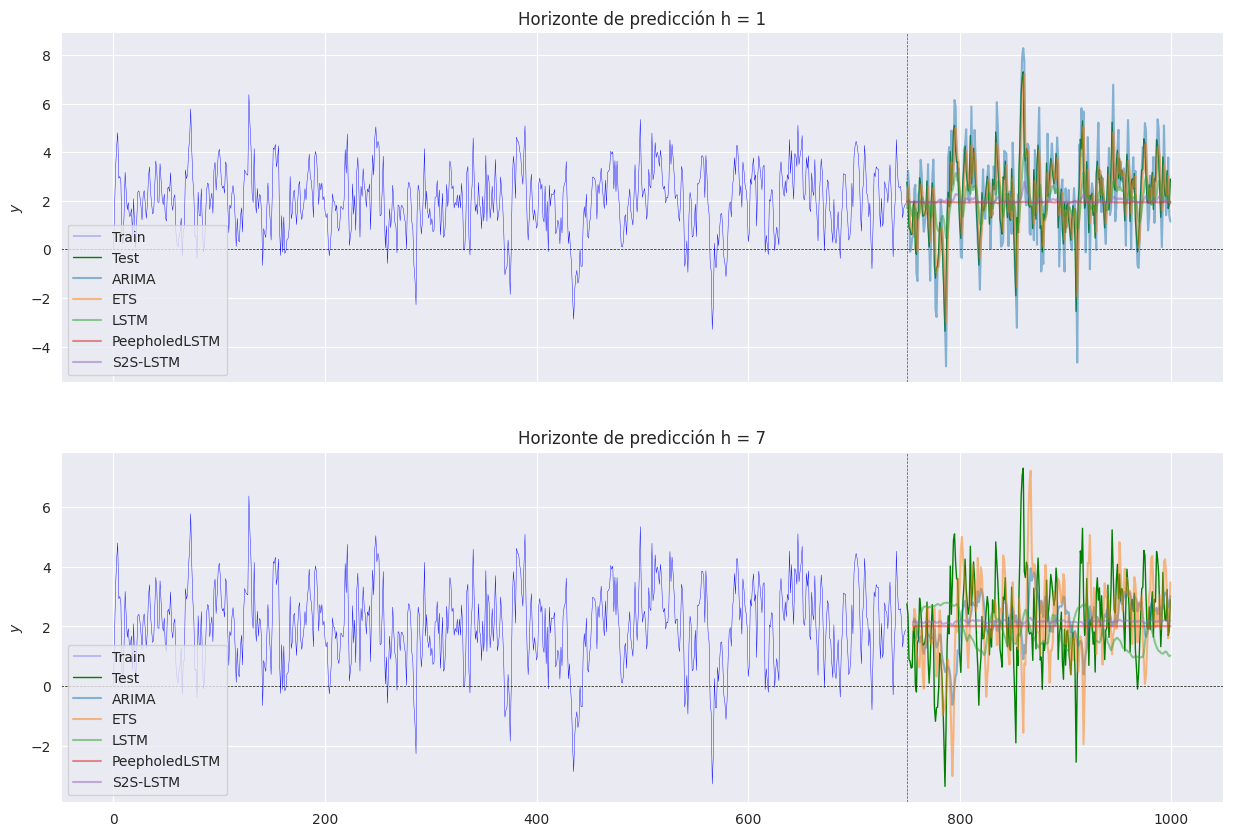

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

i=0

for h in h_list:
    axs[i].plot(msm2_y_train, color='blue', label='Train', lw=0.3)
    axs[i].plot(range(split_index, n_steps), msm2_y_test, color='green', label='Test', lw=1)
    axs[i].axvline(x=split_index, color='red', linestyle='--', lw=0.5)
    axs[i].axhline(y=0, color='black', linestyle='--', lw=0.5)

    axs[i].plot(range(split_index+h-1, n_steps), msm_best_models['msm2'][h]['arima'].predictions['iterative'], alpha=0.5, label='ARIMA')
    axs[i].plot(range(split_index+h-1, n_steps), msm_best_models['msm2'][h]['ets'].predictions['iterative'], alpha=0.5, label='ETS')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_msm2.inverse_transform(msm_best_models['msm2'][h]['stacked_lstm'].predictions['iterative']), alpha=0.5, label='LSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_msm2.inverse_transform(msm_best_models['msm2'][h]['peephole_lstm'].predictions['iterative']), alpha=0.5, label='PeepholedLSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_msm2.inverse_transform(msm_best_models['msm2'][h]['s2s_lstm'].predictions['iterative']), alpha=0.5, label='S2S-LSTM')

    axs[i].set_title("Horizonte de predicción h = "+ str(h))
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc='best')

    i+=1

plt.show()

### Forecasting Markov regime-switching model con 3 estados ocultos

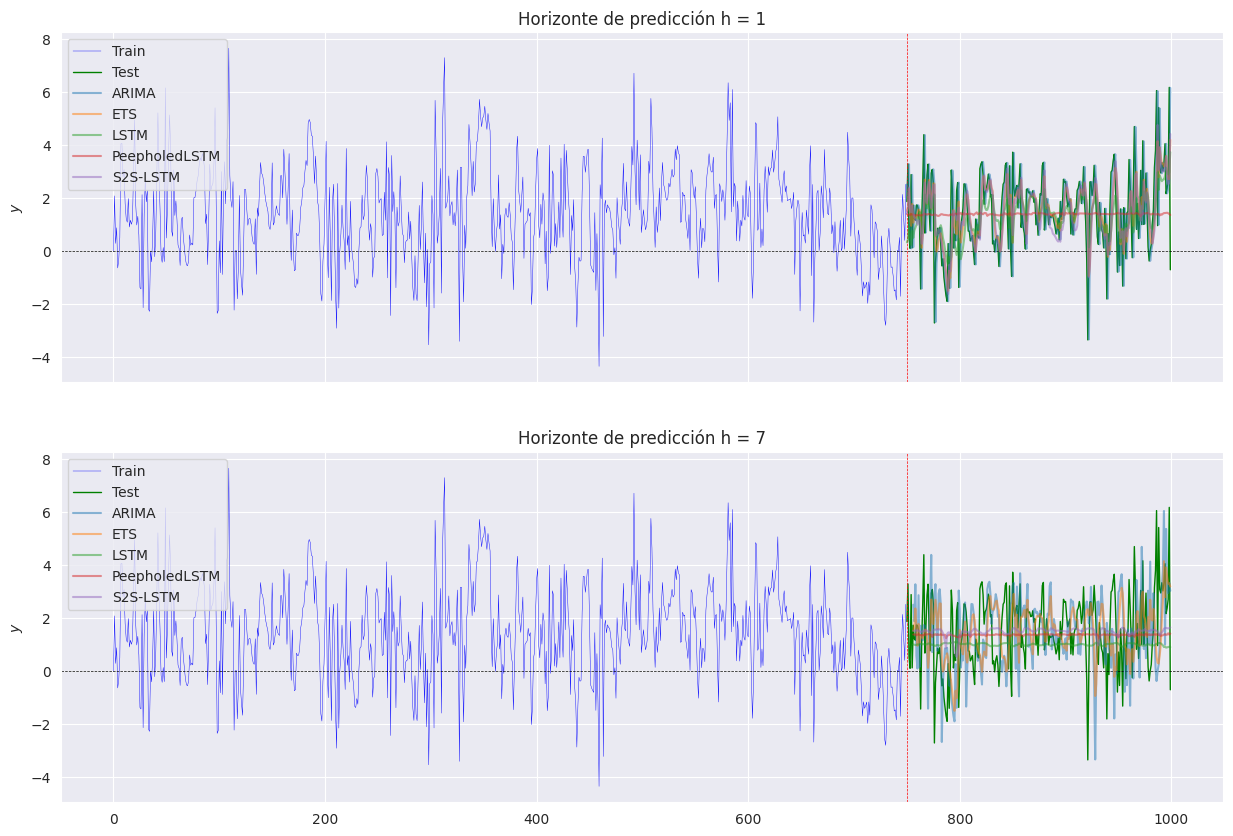

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

i=0

for h in h_list:
    axs[i].plot(msm3_y_train, color='blue', label='Train', lw=0.3)
    axs[i].plot(range(split_index, n_steps), msm3_y_test, color='green', label='Test', lw=1)
    axs[i].axvline(x=split_index, color='red', linestyle='--', lw=0.5)
    axs[i].axhline(y=0, color='black', linestyle='--', lw=0.5)

    axs[i].plot(range(split_index+h-1, n_steps), msm_best_models['msm3'][h]['arima'].predictions['iterative'], alpha=0.5, label='ARIMA')
    axs[i].plot(range(split_index+h-1, n_steps), msm_best_models['msm3'][h]['ets'].predictions['iterative'], alpha=0.5, label='ETS')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_msm3.inverse_transform(msm_best_models['msm3'][h]['stacked_lstm'].predictions['iterative']), alpha=0.5, label='LSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_msm3.inverse_transform(msm_best_models['msm3'][h]['peephole_lstm'].predictions['iterative']), alpha=0.5, label='PeepholedLSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_msm3.inverse_transform(msm_best_models['msm3'][h]['s2s_lstm'].predictions['iterative']), alpha=0.5, label='S2S-LSTM')

    axs[i].set_title("Horizonte de predicción h = "+str(h))
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc='best')

    i+=1

plt.show()

### Residuos

Se presentan adicionalmente los errores o residuos de predicción

In [ ]:
def calculate_residuals(y_true, inner_key, model, scaler=None):
    predictions = model.predictions['iterative']
    if scaler:
        predictions = scaler.inverse_transform(predictions).reshape(-1)
    return y_true[inner_key-1:] - predictions

residuals = defaultdict(lambda: defaultdict(dict))

for outer_key, dgp in msm_best_models.items():
    y_true = msm2_y_test if outer_key == 'msm2' else msm3_y_test
    scaler = scaler_msm2 if outer_key == 'msm2' else scaler_msm3

    for inner_key, h in dgp.items():
        for name, model in h.items():
            residuals[outer_key][inner_key][name] = calculate_residuals(
                y_true, inner_key, model, None if name in ['arima', 'ets'] else scaler
            )

In [ ]:
import matplotlib.ticker

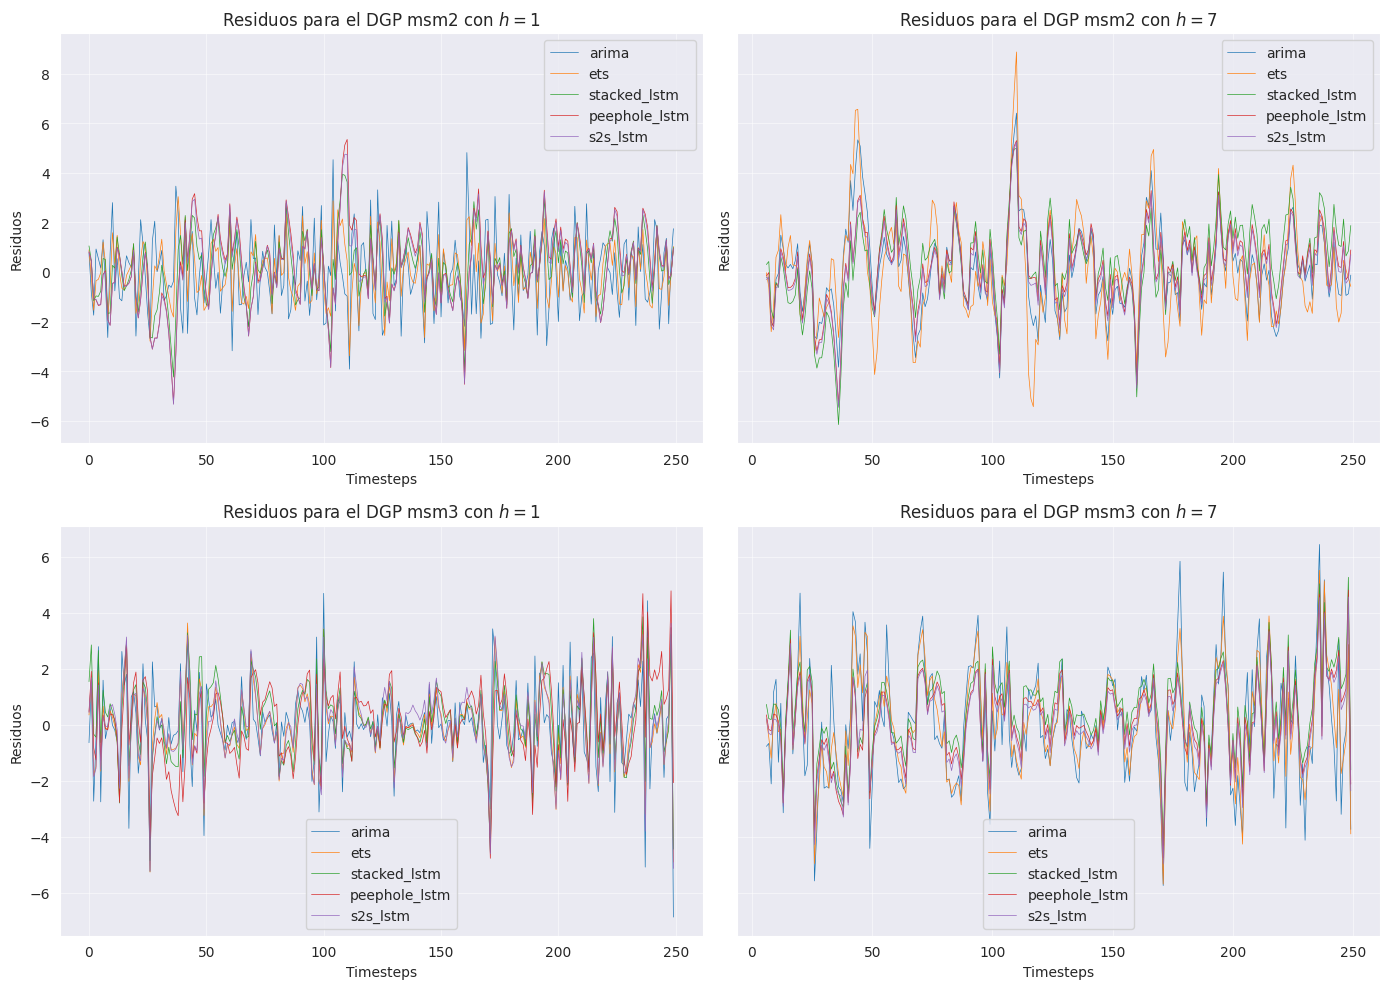

In [ ]:
def plot_residuals_grid(residuals, arma_y_test, arima_y_test):
    combinations = [(outer_key, inner_key) for outer_key, inner_dict in residuals.items() for inner_key in inner_dict.keys()]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey='row')
    axes = axes.flatten()

    for idx, (ax, (outer_key, inner_key)) in enumerate(zip(axes, combinations)):
        residuals_row = [residuals[outer_key][inner_key][name] for name in residuals[outer_key][inner_key]]

        for name, residual in residuals[outer_key][inner_key].items():
            if idx % 2 == 1:
                ax.plot(range(6, 6 + len(residual)), residual, label=f'{name}', lw=0.5)
            else:
                ax.plot(residual, label=f'{name}', lw=0.5)

        ax.set_xlabel('Timesteps')
        ax.set_ylabel('Residuos')
        ax.set_title(f'Residuos para el DGP {outer_key} con $h={inner_key}$')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.5)

    plt.tight_layout()
    plt.show()

plot_residuals_grid(residuals, msm2_y_test, msm3_y_test)

### Métricas comparativas

Para cada escenario planteado y para cada horizonte de predicción se comparan todas las versiones de los modelos (más una predicción näive en donde se forecastea $y_t$ con la última observación disponible $y_{t-1}$
) en su capacidad predictiva. En este análisis, no solo se comparan métricas como MSE o MAE directamente sino que se aplica el test de Diebold-Mariano para evaluar la significancia estadística de las diferencias entre los forecasts de cada modelo.

Primero se calculan las métricas de precisión del forecasting para una estrategia naive, en donde el mejor pronóstico es la última observación realizada de $y$
, para cualquier horizonte de pronóstico $h$
.

In [ ]:
h_list = [1,7]
scenarios = ['msm2', 'msm3']

ground_truth = list(zip([msm2_y_train, msm3_y_train],
                        [msm2_y_test, msm3_y_test]))

naive_forecasting = defaultdict((lambda: defaultdict(((lambda: defaultdict(dict))))))

s = 0

for i, j in ground_truth:
  for p in range(len(h_list)):
    forecast = forecast_evaluation(h=h_list[p],
                                    y_true = j,
                                    y_pred = np.r_[i[-1], j[:-h_list[p]]])

    naive_forecasting[scenarios[s]]['h_'+f'{h_list[p]}']['naive']['forecast'] = np.r_[i[-1], j[:-h_list[p]]]

  s += 1

A continuación, se le concatenan las métricas calculadas con los modelos ya entrenados:

In [ ]:
def evaluate_model(h, key2, y_true, model, scaler=None):
    predictions = model.predictions['iterative']
    if scaler:
        predictions = scaler.inverse_transform(predictions)
    return forecast_evaluation(h=key2, y_true=y_true, y_pred=predictions)

def process_key(dgp, y_true, scaler=None):
    results = defaultdict(dict)
    for key2, h in dgp.items():
        for name, model in h.items():
            results['h_' + f'{key2}'][name] = evaluate_model(h, key2, y_true, model, scaler if name not in ['arima', 'ets'] else None)
    return results

comparative_results = defaultdict(lambda: defaultdict(dict))

for key, dgp in msm_best_models.items():
    if key == 'msm2':
        y_true = msm2_y_test
        scaler = scaler_msm2
    else:
        y_true = msm3_y_test
        scaler = scaler_msm3
    comparative_results[key] = process_key(dgp, y_true, scaler)

In [ ]:
# Inyectamos en los resultados las métricas de predicción del forecasting näive

for dgp in ['msm2', 'msm3']:
  for h in h_list:
    if dgp == 'msm2':
      comparative_results[dgp]['h_' + f'{h}']['naive'] = forecast_evaluation(
          h = h,
          y_true = msm2_y_test,
          y_pred = naive_forecasting[dgp]['h_' + f'{h}']['naive']['forecast']
      )
    else:
      comparative_results[dgp]['h_' + f'{h}']['naive'] = forecast_evaluation(
          h = h,
          y_true = msm3_y_test,
          y_pred = naive_forecasting[dgp]['h_' + f'{h}']['naive']['forecast']
      )

In [ ]:
rows = []

for method, inner_dict in comparative_results.items():
    for horizon, model_dict in inner_dict.items():
        for model, metrics_dict in model_dict.items():
          for metric, value in metrics_dict.items():
              rows.append([method, horizon, model, metric, value])

df = pd.DataFrame(rows, columns=['DGP', 'horizon', 'model', 'metric', 'value'])
df = pd.pivot_table(df, index=['DGP','horizon','model'], columns='metric', values='value')

ordering_dgp = ['msm2', 'msm3']
ordering_horizon = ['h_1', 'h_7']
ordering_model = ['naive','arima','ets','stacked_lstm','peephole_lstm','s2s_lstm']

df_reset = df.reset_index()

df_reset['DGP'] = pd.Categorical(df_reset['DGP'], categories=ordering_dgp, ordered=True)
df_reset['horizon'] = pd.Categorical(df_reset['horizon'], categories=ordering_horizon, ordered=True)
df_reset['model'] = pd.Categorical(df_reset['model'], categories=ordering_model, ordered=True)

df_sorted = df_reset.sort_values(['DGP', 'horizon','model'])
df_sorted = df_sorted.set_index(['DGP', 'horizon', 'model'])

df_sorted

metric                          MAE       MAPE      MSE     RMSE      SMAPE
DGP  horizon model                                                         
msm2 h_1     naive          0.95285  119.17826  1.37678  1.17336   55.15679
             arima          1.20962  146.32398  2.28854  1.51279   65.94871
             ets            0.95829  120.57087  1.38670  1.17758   55.29198
             stacked_lstm   1.01009  160.20260  1.67303  1.29346   53.87764
             peephole_lstm  1.17438  152.70643  2.32488  1.52476   57.82701
             s2s_lstm       1.13232  157.96475  2.15817  1.46907   55.93271
     h_7     naive          1.62018  187.16126  4.58651  2.14161   76.33395
             arima          1.28903  173.03116  2.86143  1.69158   64.22019
             ets            1.57215  186.88415  4.33604  2.08232   74.50634
             stacked_lstm   1.31663  151.42162  2.87948  1.69690   64.69005
             peephole_lstm  1.16951  157.56320  2.32162  1.52369   56.86194
             s2s_lstm       1.15781  168.33225  2.28068  1.51019   55.72208
msm3 h_1     naive          1.03412  195.21155  2.20431  1.48469   77.73958
             arima          1.03298  194.58891  2.19654  1.48207   77.68203
             ets            0.98856  183.69066  1.78551  1.33623   75.56617
             stacked_lstm   1.01905  244.62864  1.78453  1.33586   78.72380
             peephole_lstm  1.09517  241.56890  1.95821  1.39936   75.41007
             s2s_lstm       1.02214  277.77726  1.85367  1.36150   77.09402
     h_7     naive          1.61652  412.76939  4.18837  2.04655  103.06877
             arima          1.61461  411.69184  4.17523  2.04334  103.07454
             ets            1.36241  327.24722  3.00393  1.73318   93.23562
             stacked_lstm   1.16781  182.19663  2.21386  1.48790   84.48198
             peephole_lstm  1.09815  232.61515  1.98146  1.40764   75.36504
             s2s_lstm       1.08838  251.03231  1.95929  1.39975   73.69989

#### Diebold-Mariano Test

El test de Diebold-Mariano (1995) permite comparar la precisión de 2 pronósticos. En este caso, se compara la performance para cada DGP y para cada horizonte temporal $h$ del pronóstico näive frente a los demás modelos, tomando en cuenta el error cuadrático de cada serie de pronósticos.

Para ello el test de Diebold-Mariano construye la serie de las diferencias entre los errores cuadráticos de cada modelo, la llamada **loss differential series**, la cual se define como:

$\Delta^{A,B}_{k} = (e^{A}_{k})^2-(e^{B}_{k})^2$

El test de Diebold-Mariano es un test asintótico de tipo z-score sobre el promedio de dicha serie. En este caso, se aplica su versión unilateral cuyas hipótesis son las siguientes:

* $H_0$: la precisión del modelo A (en este caso, el pronóstico näive) es mayor o igual a la del modelo B (modelo alternativo).
* $H_1$: la precisión del modelo A es menor a la del modelo B.

In [ ]:
p_value_dict = defaultdict((lambda: defaultdict(dict)))

def compute_p_value(V, P1, P2, one_sided=True):
    return dm_test(V=V, P1=P1, P2=P2, one_sided=one_sided)[1][0]

for outer_key, dgp in msm_best_models.items():
    for inner_key, h in dgp.items():
        V_test = msm2_y_test if outer_key == 'msm2' else msm3_y_test
        scaler = scaler_msm2 if outer_key == 'msm2' else scaler_msm3

        for name, model in h.items():
            predictions = msm_best_models[outer_key][inner_key][name].predictions['iterative'].reshape(-1, 1)
            naive_forecast = naive_forecasting[outer_key][f'h_{inner_key}']['naive']['forecast'].reshape(-1, 1)

            if name in ['arima', 'ets']:
                P1 = predictions
            else:
                P1 = scaler.inverse_transform(predictions)

            p_value = compute_p_value(V=V_test[inner_key-1:].reshape(-1, 1), P1=P1, P2=naive_forecast)
            p_value_dict[outer_key][inner_key][name] = round(p_value, 4)

In [ ]:
records = []

for key, nested_dict in p_value_dict.items():
    for h, models in nested_dict.items():
        for model_name, value in models.items():
            records.append((key, h, model_name, value))

df = pd.DataFrame(records, columns=['DGP', 'h', 'p_value', 'value'])

df_pivot = df.pivot_table(index=['DGP', 'h'], columns='p_value', values='value').sort_index(level=0, ascending=[True])

df_pivot

p_value   arima     ets  peephole_lstm  s2s_lstm  stacked_lstm
DGP  h                                                        
msm2 1   1.0000  0.6148         0.9998    0.9990        0.9513
     7   0.0000  0.0003         0.0000    0.0000        0.0008
msm3 1   0.0017  0.0112         0.2047    0.0303        0.0325
     7   0.0002  0.0000         0.0000    0.0000        0.0000

Se cambie el baseline de la predicción näive a la predicción generada por el modelo ARIMA

In [ ]:
p_value_dict_arima = defaultdict((lambda: defaultdict(dict)))

for outer_key, dgp in msm_best_models.items():
    for inner_key, h in dgp.items():
        V_test = msm2_y_test if outer_key == 'msm2' else msm3_y_test
        scaler = scaler_msm2 if outer_key == 'msm2' else scaler_msm3

        for name, model in h.items():
            if name == 'arima':
              pass
            else:
              predictions = msm_best_models[outer_key][inner_key][name].predictions['iterative'].reshape(-1, 1)
              baseline = msm_best_models[outer_key][inner_key]['arima'].predictions['iterative'].reshape(-1, 1)

              if name == 'ets':
                  P1 = predictions
              else:
                  P1 = scaler.inverse_transform(predictions)

              p_value = compute_p_value(V=V_test[inner_key-1:].reshape(-1, 1), P1=P1, P2=baseline)
              p_value_dict_arima[outer_key][inner_key][name] = round(p_value, 4)

In [ ]:
records = []

for key, nested_dict in p_value_dict_arima.items():
    for h, models in nested_dict.items():
        for model_name, value in models.items():
            records.append((key, h, model_name, value))

df = pd.DataFrame(records, columns=['DGP', 'h', 'p_value', 'value'])

df_pivot = df.pivot_table(index=['DGP', 'h'], columns='p_value', values='value').sort_index(level=0, ascending=[True])


In [ ]:
df_pivot

p_value     ets  peephole_lstm  s2s_lstm  stacked_lstm
DGP  h                                                
msm2 1   0.0000         0.5436    0.3408        0.0116
     7   1.0000         0.0033    0.0021        0.5244
msm3 1   0.0117         0.2111    0.0318        0.0340
     7   0.0000         0.0000    0.0000        0.0000

Por último, se vuelve a cambiar las predicciones baseline por aquellas generadas por el modelo ETS

In [ ]:
p_value_dict_ets = defaultdict((lambda: defaultdict(dict)))

for outer_key, dgp in msm_best_models.items():
    for inner_key, h in dgp.items():
        V_test = msm2_y_test if outer_key == 'msm2' else msm3_y_test
        scaler = scaler_msm2 if outer_key == 'msm2' else scaler_msm3

        for name, model in h.items():
            if name == 'ets':
              pass
            else:
              predictions = msm_best_models[outer_key][inner_key][name].predictions['iterative'].reshape(-1, 1)
              baseline = msm_best_models[outer_key][inner_key]['ets'].predictions['iterative'].reshape(-1, 1)

              if name == 'arima':
                  P1 = predictions
              else:
                  P1 = scaler.inverse_transform(predictions)

              p_value = compute_p_value(V=V_test[inner_key-1:].reshape(-1, 1), P1=P1, P2=baseline)
              p_value_dict_ets[outer_key][inner_key][name] = round(p_value, 4)

In [ ]:
records = []

for key, nested_dict in p_value_dict_ets.items():
    for h, models in nested_dict.items():
        for model_name, value in models.items():
            records.append((key, h, model_name, value))

df = pd.DataFrame(records, columns=['DGP', 'h', 'p_value', 'value'])

df_pivot = df.pivot_table(index=['DGP', 'h'], columns='p_value', values='value').sort_index(level=0, ascending=[True])

df_pivot


p_value   arima  peephole_lstm  s2s_lstm  stacked_lstm
DGP  h                                                
msm2 1   1.0000         0.9998    0.9993        0.9607
     7   0.0000         0.0000    0.0000        0.0020
msm3 1   0.9883         0.8313    0.9479        0.4956
     7   1.0000         0.0000    0.0000        0.0001